# Load modules

In [47]:
import numpy as np
import pandas as pd
import xgboost as xgb

import datetime
import matplotlib.pyplot as plt
import seaborn as sns
import os

import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM

from sklearn.metrics import accuracy_score

from sklearn.model_selection import train_test_split, GridSearchCV

%load_ext tensorboard

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


# Load data

In [48]:
data = np.load(os.path.join('data', 'dataset_smile_challenge.npy'), allow_pickle = True).item()

#training dataset 
train = data['train']

deep_features_train = train['deep_features'] # for deep features.
deep_features_train['ECG_features_C'] # conv1d backbone based features for ECG signal.
deep_features_train['ECG_features_T'] # transformer backbone based features for ECG signal   
handcrafted_features_train = train['hand_crafted_features'] # for hand-crafted features.

#test dataset
test = data['test']

deep_features_test = test['deep_features'] # for deep features {'ECG_features_C', 'ECG_features_T'}.
handcrafted_features_test = test['hand_crafted_features'] # for hand-crafted features {'ECG_features', 'GSR_features'}.

# extracting labels and converting labels >= 1 to just 1.
y_train = train['labels']
th = 1
y_train[y_train<th] = 0
y_train[y_train>0] = 1



# Analyze dataset

<AxesSubplot:>

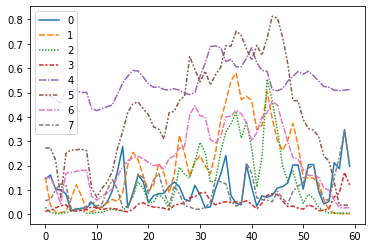

In [49]:
#Visualize a data sample
sns.lineplot(data=handcrafted_features_train['ECG_features'][0])

In [50]:
print('Prevalence of CLASS = 0: ' + str(100*np.sum(y_train)/y_train.shape[0]) + '%')
print('Prevalence of CLASS = 1: ' + str(100*(y_train.shape[0]-np.sum(y_train))/y_train.shape[0]) + '%')

Prevalence of CLASS = 0: 52.7536231884058%
Prevalence of CLASS = 1: 47.2463768115942%


# Model building

In [51]:
model = tf.keras.models.Sequential([
 tf.keras.layers.LSTM(64, input_shape = handcrafted_features_train['GSR_features'][0].shape),
 tf.keras.layers.Dropout(0.2),
 tf.keras.layers.Dense(1, activation='sigmoid')
])
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

print(model.summary())

model.fit(x=handcrafted_features_train['GSR_features'], 
          y=y_train, 
          epochs=13,
          validation_split=0.2,
          callbacks=[tensorboard_callback],
         batch_size = 64)
# Final evaluation of the model
scores = model.evaluate(handcrafted_features_train['GSR_features'], y_train, verbose=0)

Model: "sequential_16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_15 (LSTM)              (None, 64)                19712     
                                                                 
 dropout_14 (Dropout)        (None, 64)                0         
                                                                 
 dense_14 (Dense)            (None, 1)                 65        
                                                                 
Total params: 19,777
Trainable params: 19,777
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/13
26/26 [==============================] - 2s 40ms/step - loss: 0.6925 - accuracy: 0.5344 - val_loss: 0.6670 - val_accuracy: 0.6473
Epoch 2/13
26/26 [==============================] - 1s 28ms/step - loss: 0.6884 - accuracy: 0.5562 - val_loss: 0.6743 - val_accuracy: 0.6449
Epoch 3/13
26/26 [========

In [52]:
%tensorboard --logdir logs/fit

Reusing TensorBoard on port 6006 (pid 16446), started 0:05:50 ago. (Use '!kill 16446' to kill it.)

# Make and save predictions

In [53]:
y_hat_test = model.predict(handcrafted_features_test['GSR_features'])
th = 0.5
y_hat_test[y_hat_test >= th] = 1
y_hat_test[y_hat_test < th] = 0
np.savetxt(os.path.join('submission', 'answer.txt'),y_hat_test.astype(int),fmt='%1d')

31/31 [==============================] - 1s 6ms/step
